## Capstone Project - Winonsin Breast Cancer Diagnosis Deep Learning Revisited






#### Import necessary libraries

In [113]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
# from sklearn.model_selection import ShuffleSplit

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

# Pretty display for notebooks
%matplotlib inline

#### Load in WBCD dataset

In [114]:
# Load the Boston housing dataset
headers = ["ID","CT","UCSize","UCShape","MA","SECSize","BN","BC","NN","Mitoses","Diagnosis"]
data = pd.read_csv('breast-cancer-wisconsin.csv', na_values='?', header=None, index_col=['ID'], names = headers)
data = data.reset_index(drop=True)

#### Handle missing data
* There are 16 Bare Nuclei entries missing and marked as "?". Those question marks were replaced as NaN during data loading. 
* All the NaN entries are filled with zero.

In [115]:
data = data.fillna(0)
data.describe()

,CT,UCSize,UCShape,MA,SECSize,BN,BC,NN,Mitoses,Diagnosis
count,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000
mean,4.417740,3.134478,3.207439,2.806867,3.216023,3.463519,3.437768,2.866953,1.589413,2.689557
std,2.815741,3.051459,2.971913,2.855379,2.214300,3.640708,2.438364,3.053634,1.715078,0.951273
min,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,2.000000
25%,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000
50%,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000,2.000000
75%,6.000000,5.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,1.000000,4.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


#### Value ranges of data columns

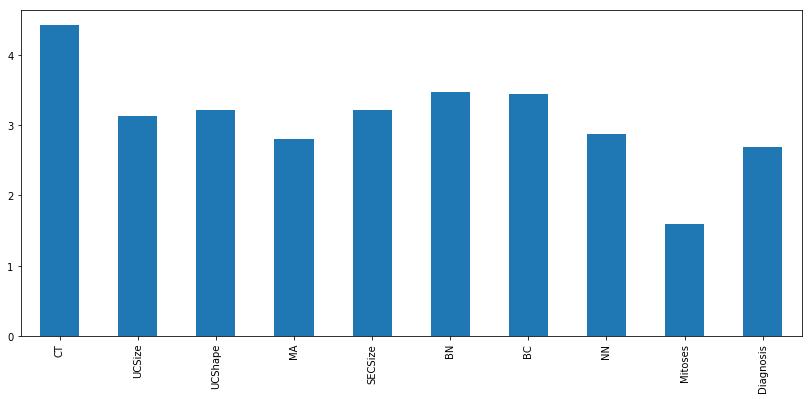

In [116]:
# Import Seaborn, a very powerful library for Data Visualisation
import seaborn as sns
data_mean = data.describe().loc['mean']
data_mean.plot(kind='bar', figsize=(14,6))

#### Samples from dataset labled as B

In [117]:
data_B = data[data['Diagnosis'] == 2]
data_B.describe()

,CT,UCSize,UCShape,MA,SECSize,BN,BC,NN,Mitoses,Diagnosis
count,458.000000,458.000000,458.000000,458.000000,458.000000,458.000000,458.000000,458.000000,458.000000,458.0
mean,2.956332,1.325328,1.443231,1.364629,2.120087,1.305677,2.100437,1.290393,1.063319,2.0
std,1.674318,0.907694,0.997836,0.996830,0.917130,1.182666,1.080339,1.058856,0.501995,0.0
min,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,2.0
25%,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,2.0
50%,3.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.0
75%,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000,2.0
max,8.000000,9.000000,8.000000,10.000000,10.000000,10.000000,7.000000,9.000000,8.000000,2.0


#### Samples from dataset labeled as M

In [118]:
data_M = data[data['Diagnosis'] == 4]
data_M.describe()

,CT,UCSize,UCShape,MA,SECSize,BN,BC,NN,Mitoses,Diagnosis
count,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.0
mean,7.195021,6.572614,6.560166,5.547718,5.298755,7.564315,5.979253,5.863071,2.589212,4.0
std,2.428849,2.719512,2.562045,3.210465,2.451606,3.180182,2.273852,3.350672,2.557939,0.0
min,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,4.0
25%,5.000000,4.000000,4.000000,3.000000,3.000000,5.000000,4.000000,3.000000,1.000000,4.0
50%,8.000000,6.000000,6.000000,5.000000,5.000000,10.000000,7.000000,6.000000,1.000000,4.0
75%,10.000000,10.000000,9.000000,8.000000,6.000000,10.000000,7.000000,10.000000,3.000000,4.0
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.0


#### Bar chart of the total numbers of B and M

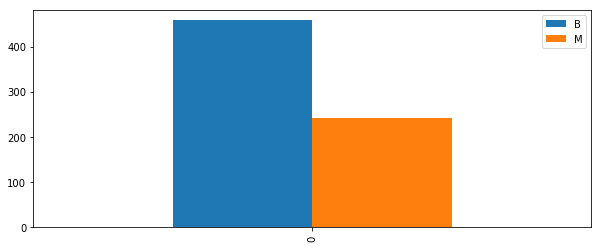

In [119]:
B_M_data = {'B': [data_B.shape[0]], 'M': [data_M.shape[0]]}
B_M_df = pd.DataFrame(data=B_M_data)
B_M_df.plot(kind='bar', figsize=(10,4))

#### Define a data generation function with random noise

In [120]:
def generateData(data1):
    # make a copy of data
    data2 = data1.copy()

    # separate labels from features
    diagnosis2 = data2['Diagnosis'] # labels
    features2 = data2.drop(['Diagnosis'], axis = 1)
    features2_headers = ["CT","UCSize","UCShape","MA","SECSize","BN","BC","NN","Mitoses"]

    mean, sigma = 0, 0.1 
    # creating a noise with the same dimension as the dataset 
    noise = np.random.normal(mean, sigma, features2.shape) 
    features2 = features2.apply(pd.to_numeric, errors='ignore')
    features2_with_noise = features2.add(pd.DataFrame(noise, columns = features2_headers), fill_value=0)
    data2 = pd.concat([features2_with_noise, pd.DataFrame(diagnosis2)], axis = 1)
    
    return data2

#### Expand the set of data samples labeled as M

In [121]:
data_M_copy = data_M.copy();

new_data_M = generateData(data_M_copy)
data_M = data_M.append(new_data_M, ignore_index=True)

data_M = data_M[data_M['Diagnosis'] >= 4.0]
data_M.describe()

,CT,UCSize,UCShape,MA,SECSize,BN,BC,NN,Mitoses,Diagnosis
count,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.0
mean,7.195492,6.570511,6.562036,5.548963,5.297437,7.563626,5.979376,5.863072,2.586161,4.0
std,2.427537,2.717679,2.558735,3.207841,2.451307,3.178303,2.271505,3.346726,2.555819,0.0
min,1.000000,1.000000,1.000000,0.806466,0.984798,-0.063127,1.000000,0.716100,0.760108,4.0
25%,5.000000,4.000000,4.028996,3.000000,3.000000,5.000000,4.000000,3.000000,1.000000,4.0
50%,8.000000,6.019143,6.216758,5.000000,5.000000,9.972578,6.956922,6.000000,1.000000,4.0
75%,9.999854,9.956956,9.000000,8.017039,6.140421,10.000000,7.113238,9.836649,3.000000,4.0
max,10.129121,10.244606,10.155636,10.172940,10.247693,10.193267,10.032359,10.319410,10.102157,4.0


#### Bar chart of the total numbers of B and M after expanding the set of samples labeled as M

,B,M
0,458,482


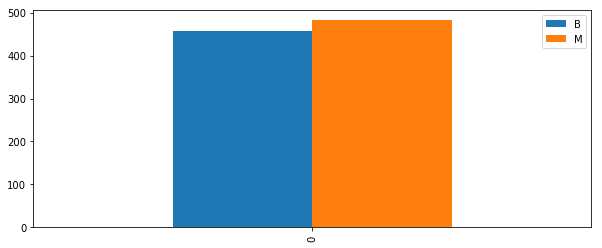

In [122]:
B_M_data = {'B': [data_B.shape[0]], 'M': [data_M.shape[0]]}
B_M_df = pd.DataFrame(data=B_M_data)
B_M_df.plot(kind='bar', figsize=(10,4))
B_M_def.head()

#### Combine the new set of M samples with the original set of B samples into one new dataset

In [123]:

data = data_B.append(data_M, ignore_index=True)
data.describe()

,CT,UCSize,UCShape,MA,SECSize,BN,BC,NN,Mitoses,Diagnosis
count,940.000000,940.000000,940.000000,940.000000,940.000000,940.000000,940.000000,940.000000,940.000000,940.000000
mean,5.130029,4.014879,4.067980,3.510213,3.749324,4.514540,4.089425,3.635107,1.844180,3.025532
std,2.979508,3.326433,3.223596,3.183351,2.452007,3.955979,2.640868,3.393027,2.012151,1.000206
min,1.000000,1.000000,1.000000,0.806466,0.984798,-0.063127,1.000000,0.716100,0.760108,2.000000
25%,3.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000
50%,5.000000,3.000000,3.000000,2.000000,3.000000,2.000000,3.000000,1.000000,1.000000,4.000000
75%,8.000000,6.973556,6.993410,5.131540,5.000000,9.998794,7.000000,6.000000,1.094619,4.000000
max,10.129121,10.244606,10.155636,10.172940,10.247693,10.193267,10.032359,10.319410,10.102157,4.000000


#### Expand the new combined dataset

In [124]:
data_copy = data;

new_data = generateData(data_copy)
data = data.append(new_data, ignore_index=True)

data = data.fillna(0)

print("data size = ", data.shape[0])

('data size = ', 1880)


#### Scale dataset to the range of [0, 1]

In [125]:
# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler()
numerical = ["Diagnosis","CT","UCSize","UCShape","MA","SECSize","BN","BC","NN","Mitoses"]
data[numerical] = scaler.fit_transform(data[numerical])

#### Separate Labels/Classes from Features

In [126]:
diagnosis = data['Diagnosis']
features = data.drop(['Diagnosis'], axis = 1)

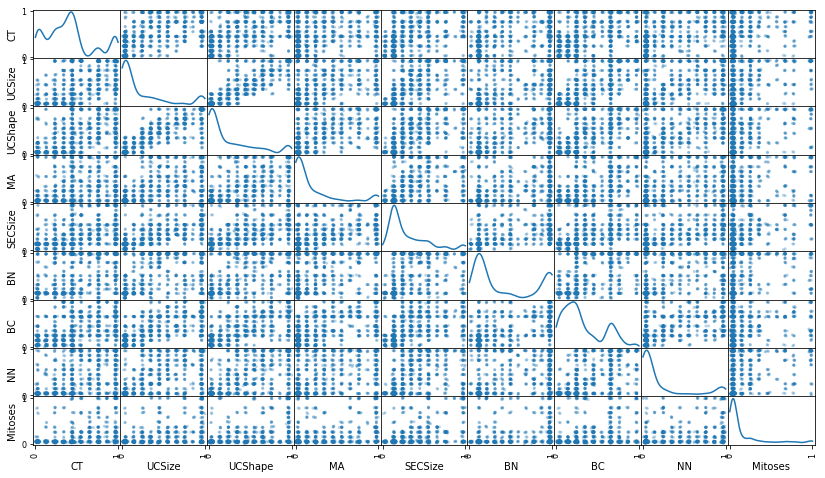

In [127]:
# Produce a scatter matrix for each pair of features in the data
pd.plotting.scatter_matrix(features, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

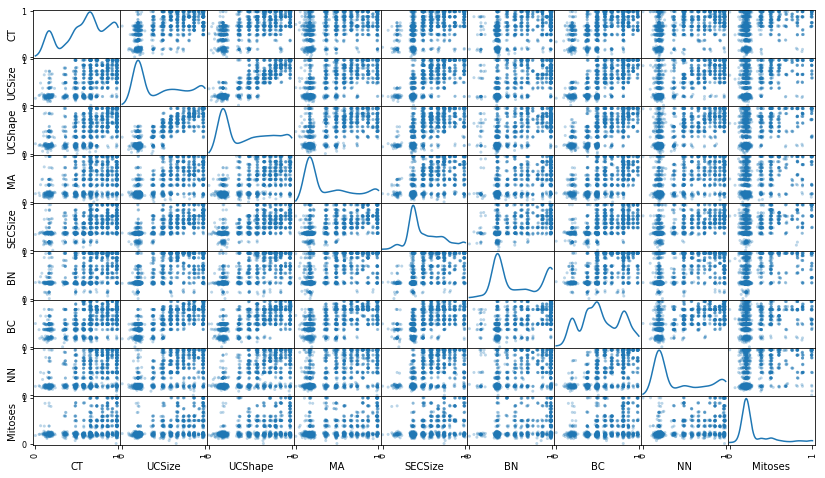

In [128]:
# Scale the data using squared root transformation
sqrt_features = features.copy()

for feature_name in sqrt_features.columns:
    sqrt_features[feature_name] = np.sqrt(sqrt_features[feature_name]) 
    
# sqrt_features = scaler.fit_transform(sqrt_features)

# Produce a scatter matrix for each pair of newly-transformed features
pd.plotting.scatter_matrix(pd.DataFrame(sqrt_features), alpha = 0.3, figsize = (14,8), diagonal = 'kde');

# convert numpy ndarray into Pandas DataFrame
features = pd.DataFrame(sqrt_features)

#### Split dataset into training and testing datasets

In [129]:
from sklearn.model_selection import train_test_split

# Shuffle and split the data into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(features, diagnosis, test_size=0.25, random_state=42)

#### Reindex 

In [130]:
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

#### Convert Pandas DataFrame to Numpy ndarray
* This conversion is necessary because Pandas DataFrame is not consist with Keras API.

In [131]:
X_train = X_train.values
y_train = y_train.values
X_test  = X_test.values
y_test  = y_test.values

#### Classify dataset using Random Forest Classifier

In [132]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

score = rfc.score(X_test, y_test)
print("score = ", score)

('score = ', 0.97446808510638294)


#### Deep learning

In [133]:
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import Sequential
import keras
import keras.utils
from keras import utils as np_utils

#### Define NN Architecture
* add Dropout(0.5) does not produce noticable performance in accuracy once the epochs >= 500.

In [134]:
model = Sequential()

#Define your architecture.
model.add(Dense(9, activation='relu', input_dim=9))
model.add(Dropout(0.5))
model.add(Dense(5, activation='relu', input_shape=(9,)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid', input_shape=(5,)))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 9)                 90        
_________________________________________________________________
dropout_5 (Dropout)          (None, 9)                 0         
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 50        
_________________________________________________________________
dropout_6 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 6         
Total params: 146
Trainable params: 146
Non-trainable params: 0
_________________________________________________________________


#### Compile NN Model

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='Adam',
              metrics=['binary_accuracy'])

#### Train NN Model

In [ ]:
model.fit(X_train, y_train, epochs=800, batch_size=16) # (500, 16) = 0.974286, 32 - 0.968571

Epoch 1/800
1410/1410 [==============================] - 0s - loss: 0.7140 - binary_accuracy: 0.5106     
Epoch 2/800
1410/1410 [==============================] - 0s - loss: 0.6720 - binary_accuracy: 0.5340     
Epoch 3/800
 976/1410 [===================>..........] - ETA: 0s - loss: 0.6379 - binary_accuracy: 0.5738

#### Test NN Model

In [ ]:
score = model.evaluate(X_test, y_test, batch_size=16) # 16 - 0.974286, 32 - 0.968571
print("score = ", score)

#### Draw ROC Curve

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn import metrics

y_pred = model.predict_proba(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()